In [66]:
import tensorflow as tf
from tensorflow import saved_model  
from basic_pitch import ICASSP_2022_MODEL_PATH
from tensorflow.keras.models import Model


from basic_pitch import models
from basic_pitch.callbacks import VisualizeCallback
from basic_pitch.constants import DATASET_SAMPLING_FREQUENCY
from basic_pitch.dataset import tf_example_deserialization

model = models.model(no_contours=False)



# model_path = ICASSP_2022_MODEL_PATH
model_path = "../My_models/spotify-hwd/model.best"
oldmodel = saved_model.load(str(model_path))
weights = oldmodel.variables
model.set_weights(weights)

# Ora puoi fare una predizione su un dato input


In [67]:
import tensorflow as tf
import numpy as np
import librosa
import os


from basic_pitch.constants import (
    AUDIO_SAMPLE_RATE,
    AUDIO_N_SAMPLES,
    ANNOTATIONS_FPS,
    FFT_HOP,
)

def window_audio_file(audio_original, hop_size):
    """
    Pad appropriately an audio file, and return as
    windowed signal, with window length = AUDIO_N_SAMPLES

    Returns
    -------
    audio_windowed: tensor with shape (n_windows, AUDIO_N_SAMPLES, 1)
        audio windowed into fixed length chunks
    window_times: list of {'start':.., 'end':...} objects (times in seconds)

    """

    # create a tensor with shape (n_windows, sample_one_window, 1) where window size is AUDIO_N_SAMPLES
    audio_windowed = tf.expand_dims(
        tf.signal.frame(audio_original, AUDIO_N_SAMPLES, hop_size, pad_end=True, pad_value=0),
        axis=-1,
    )

    # create a list of dictionaries with start and end times of each window
    window_times = [
        {
            "start": t_start,
            "end": t_start + (AUDIO_N_SAMPLES / AUDIO_SAMPLE_RATE),
        }
        for t_start in np.arange(audio_windowed.shape[0]) * hop_size / AUDIO_SAMPLE_RATE
    ]
    return audio_windowed, window_times

def get_audio_input(audio_path, overlap_len, hop_size):
    """
    Read wav file (as mono), pad appropriately, and return as
    windowed signal, with window length = AUDIO_N_SAMPLES

    Returns
    -------
    audio_windowed: tensor with shape (n_windows, AUDIO_N_SAMPLES, 1)
        audio windowed into fixed length chunks
    window_times: list of {'start':.., 'end':...} objects (times in seconds)
    audio_original_length: int
        length of original audio file, in frames, BEFORE padding.

    """
    assert overlap_len % 2 == 0, "overlap_length must be even, got {}".format(overlap_len)

    #load audio file and get original length
    audio_original, _ = librosa.load(audio_path, sr=AUDIO_SAMPLE_RATE, mono=True)
    original_length = audio_original.shape[0]

    # pad audio with zeros at the beginning
    audio_original = np.concatenate([np.zeros((int(overlap_len / 2),), dtype=np.float32), audio_original])

    # pad audio with zeros at the end and divide into windows
    audio_windowed, window_times = window_audio_file(audio_original, hop_size)

    return audio_windowed, window_times, original_length

def unwrap_output(output, audio_original_length, n_overlapping_frames):
    """Unwrap batched model predictions to a single matrix.

    Parameters:
        output : array (n_batches, n_times_short, n_freqs)
        audio_original_length : length of original audio signal (in samples)
        n_overlapping_frames : number of overlapping frames in the output

    Return:
        array (n_times, n_freqs)
    """
    
    # check of dimensions
    raw_output = output.numpy()
    if len(raw_output.shape) != 3:
        return None

    # remove half of the overlapping frames from beginning and end
    n_olap = int(0.5 * n_overlapping_frames)
    if n_olap > 0:
        raw_output = raw_output[:, n_olap:-n_olap, :]
    output_shape = raw_output.shape

    # compute number of output timeframes in the original audio
    n_output_frames_original = int(np.floor(audio_original_length * (ANNOTATIONS_FPS / AUDIO_SAMPLE_RATE)))
    
    # reshape to (n_times, n_freqs) and trim to original audio length (paste together batches)
    unwrapped_output = raw_output.reshape(output_shape[0] * output_shape[1], output_shape[2])
    return unwrapped_output[:n_output_frames_original, :] 


def run_inference(audio_path, model):
    n_overlapping_frames = 30 # number of overlapping frames
    overlap_len = n_overlapping_frames * FFT_HOP # number of samples in the overlapping region
    hop_size = AUDIO_N_SAMPLES - overlap_len # hop size for the audio windows

    # get audio input and divide into windows
    audio_windowed, _, audio_original_length = get_audio_input(audio_path, overlap_len, hop_size)

    # predict
    output = model(audio_windowed)
    
    # unwrap output to a single matrix for eache output key (note, onset, contour)
    unwrapped_output = {k: unwrap_output(output[k], audio_original_length, n_overlapping_frames) for k in output}
    return unwrapped_output


audio_path = os.path.join(os.path.expanduser('~'),'mir_datasets','hwd','MLEndHWD_Frozen_Audio_Files', '5798.wav')

outputs = run_inference(audio_path, model)

In [68]:
import numpy as np
np.set_printoptions(threshold=np.inf)

with open('Intemediate_outputs.txt', 'w') as f:
    for output in outputs.values():
        f.write(f"{output}\n")

In [69]:
import pandas as pd
import json
from typing import Dict, List, Tuple
from IPython.display import display

import os


benchmark = pd.read_json("./saved_models/icassp_2022/model.best.json",orient='index')

guitarset_b = benchmark[benchmark.index.str[0].str.isnumeric()]
slakh_b = benchmark[benchmark.index.str.startswith('Track')]
hwd_b = benchmark[~benchmark.index.str[0].str.isnumeric() & ~benchmark.index.str.startswith('Track')]

display(guitarset_b.describe())
display(slakh_b.describe())
display(hwd_b.describe())

display(benchmark.describe())

,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000,31.000000
mean,0.547995,0.538603,0.538590,0.880674,0.796781,0.774948,0.777741,0.777782,0.834605,0.811038,0.814197,0.736634,0.714199,0.717496
std,0.123860,0.144330,0.128643,0.026965,0.095202,0.112228,0.076952,0.045692,0.087579,0.103467,0.059728,0.095766,0.097799,0.064758
min,0.338415,0.161103,0.218289,0.821399,0.626087,0.417997,0.566372,0.651982,0.660870,0.458636,0.621436,0.547826,0.451379,0.611603
25%,0.444096,0.447808,0.438965,0.863377,0.719571,0.729947,0.726835,0.743653,0.783171,0.754979,0.782828,0.659780,0.657601,0.665437
50%,0.554217,0.500000,0.533333,0.883062,0.811594,0.777174,0.768166,0.781781,0.824561,0.836158,0.823529,0.732704,0.720621,0.709220
75%,0.648172,0.641371,0.648450,0.892630,0.880201,0.851397,0.848098,0.812954,0.906929,0.868826,0.857738,0.804061,0.781746,0.779724
max,0.768116,0.868852,0.815385,0.929934,0.942529,0.937500,0.900585,0.854030,0.963415,0.947917,0.905797,0.948171,0.901639,0.846154


,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000,21.000000
mean,0.161878,0.225239,0.177375,0.609104,0.354362,0.514583,0.388185,0.455876,0.430439,0.644749,0.475869,0.372768,0.688829,0.434545
std,0.196700,0.262113,0.209038,0.398761,0.309484,0.384265,0.307876,0.292042,0.327634,0.347901,0.312191,0.222328,0.257464,0.199832
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008929,0.042654,0.014766,0.044890,0.056424,0.050000
25%,0.000000,0.000000,0.000000,0.000000,0.027439,0.101124,0.043165,0.263559,0.060976,0.377327,0.095923,0.205357,0.616401,0.307692
50%,0.050000,0.152284,0.076923,0.843256,0.332011,0.500000,0.459983,0.502433,0.464286,0.811111,0.539299,0.307407,0.750000,0.404381
75%,0.343831,0.352941,0.367811,0.887445,0.600707,0.874594,0.626263,0.743501,0.748737,0.948649,0.700611,0.586281,0.864583,0.635438
max,0.573099,0.797909,0.588589,0.926148,0.927966,1.000000,0.883846,0.850184,0.957797,1.000000,0.899468,0.766082,1.000000,0.786787


,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,651.0,651.0,651.0,651.0,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000,651.000000
mean,0.0,0.0,0.0,0.0,0.000042,0.000040,0.000041,0.000757,0.193748,0.184304,0.169361,0.287866,0.273198,0.251630
std,0.0,0.0,0.0,0.0,0.001059,0.001031,0.001045,0.019320,0.105315,0.117085,0.093802,0.130791,0.149672,0.116133
min,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.121831,0.092215,0.100360,0.217787,0.160000,0.166667
50%,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.194444,0.175000,0.166667,0.292683,0.270270,0.259740
75%,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.266667,0.268762,0.236068,0.371761,0.392857,0.337662
max,0.0,0.0,0.0,0.0,0.027027,0.026316,0.026667,0.492954,0.666667,0.600000,0.441558,1.000000,0.692308,0.526316


,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000,703.000000
mean,0.029000,0.030479,0.029049,0.057030,0.045759,0.049582,0.045930,0.048617,0.229078,0.225695,0.206953,0.310191,0.305061,0.277637
std,0.122314,0.127457,0.121894,0.215991,0.181140,0.191638,0.179056,0.182837,0.179493,0.196396,0.175595,0.162017,0.189153,0.153988
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.100000,0.105263,0.221111,0.166667,0.171526
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.194444,0.172043,0.300000,0.288889,0.270270
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.296296,0.251437,0.389566,0.407407,0.353890
max,0.768116,0.868852,0.815385,0.929934,0.942529,1.000000,0.900585,0.854030,0.963415,1.000000,0.905797,1.000000,1.000000,0.846154


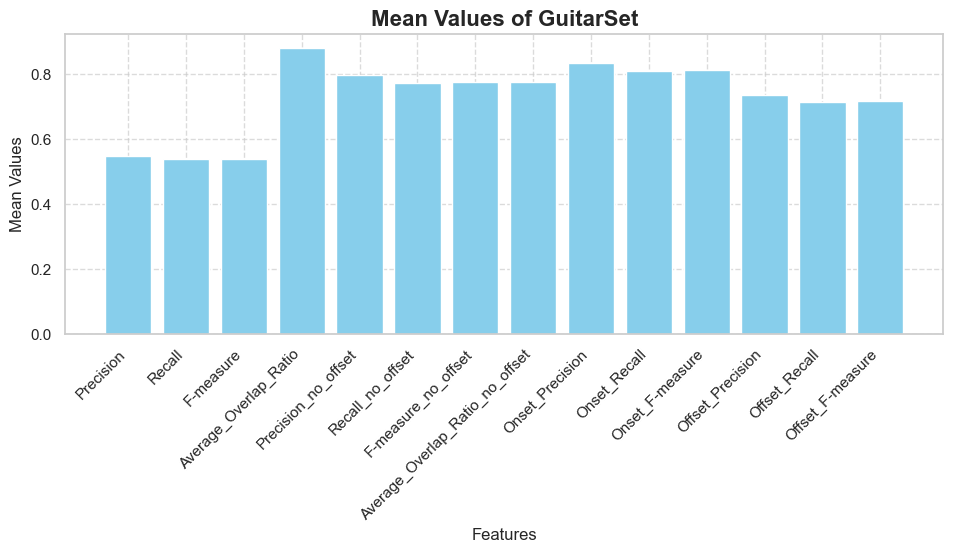

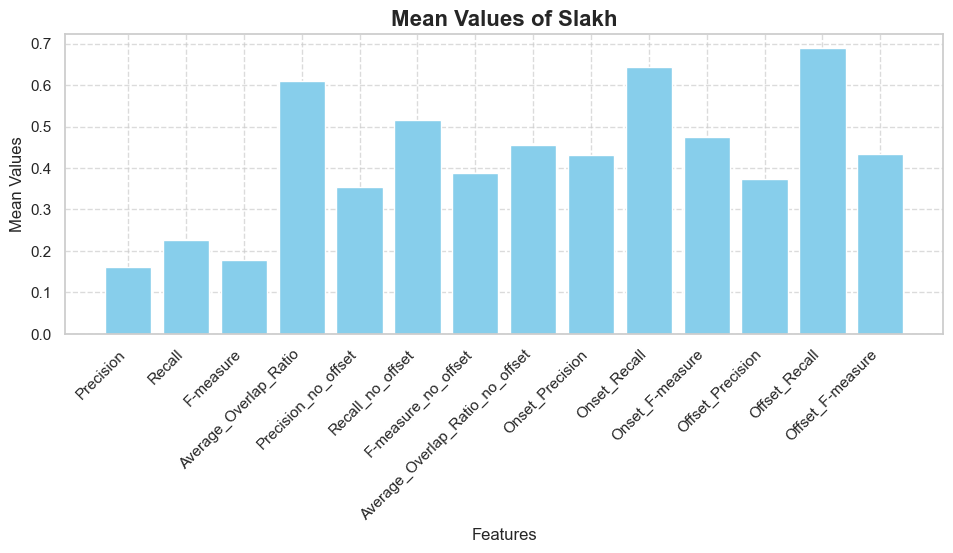

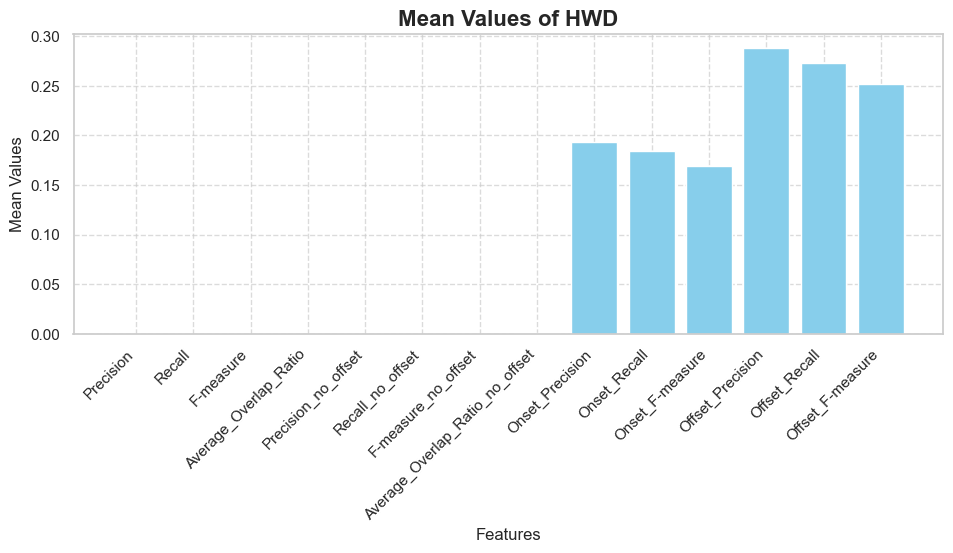

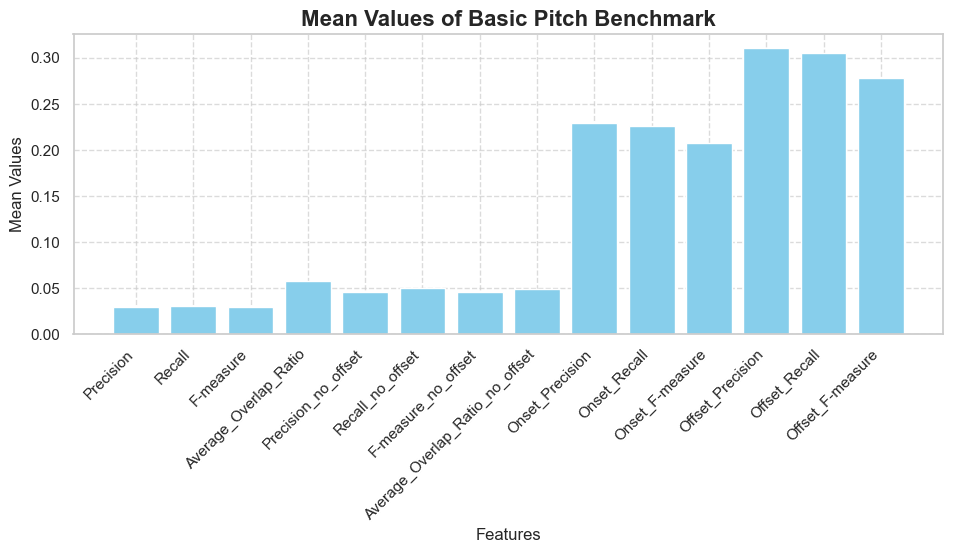

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the overall aesthetics
sns.set(style="whitegrid")

def plot_mean(data, dataset_name):
    # Extract the mean from the .describe() output
    means = data.describe().loc['mean']

    # Plot the mean values
    plt.figure(figsize=(10, 6))
    plt.bar(means.index, means, color='skyblue')

    # Set plot title and labels
    plt.title(f'Mean Values of {dataset_name}', fontsize=16, weight='bold')
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Mean Values', fontsize=12)

    # Rotate x-ticks for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Add a grid for better readability
    plt.grid(True, linestyle='--', alpha=0.7)

    # Adjust layout to avoid overlap
    plt.tight_layout(pad=2.0)
    
    # Display the plot
    plt.show()

plot_mean(guitarset_b, 'GuitarSet')
plot_mean(slakh_b, 'Slakh')
plot_mean(hwd_b, 'HWD')
plot_mean(benchmark, 'Basic Pitch Benchmark')


In [71]:
# load all the json files in my_models
def load_json_files(path):

    data = pd.DataFrame()
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith('.json'):
                with open(os.path.join(root, file)) as f:
                    data=pd.concat([data,pd.read_json(f, orient='index')])
    return data


data= load_json_files('../My_models')
data

,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure,instrument
Potter_Whistle_160_0004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.089286,0.740741,0.159363,0.084821,0.703704,0.151394,whistle
Potter_Whistle_213_0008,0.000000,0.000000,0.000000,0.000000,0.004831,0.064516,0.008989,0.169799,0.062802,0.838710,0.116854,0.070048,0.935484,0.130337,whistle
Potter_Hum_11_0013,0.000000,0.000000,0.000000,0.000000,0.002358,0.037037,0.004435,0.574218,0.058962,0.925926,0.110865,0.063679,1.000000,0.119734,hum
Potter_Hum_198_0021,0.004107,0.068966,0.007752,0.903441,0.006160,0.103448,0.011628,0.764834,0.055441,0.931034,0.104651,0.059548,1.000000,0.112403,hum
Potter_Hum_82_0025,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.085837,0.689655,0.152672,0.090129,0.724138,0.160305,hum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Track00013-S06,0.000000,0.000000,0.000000,0.000000,0.002247,0.033333,0.004211,0.106695,0.040449,0.600000,0.075789,0.062921,0.933333,0.117895,Synth Lead
Track00015-S03,0.000000,0.000000,0.000000,0.000000,0.008772,0.025000,0.012987,0.307210,0.111842,0.318750,0.165584,0.288012,0.820833,0.426407,Strings (continued)
Track00016-S00,0.000000,0.000000,0.000000,0.000000,0.000666,0.001235,0.000865,0.104254,0.278296,0.516049,0.361592,0.237683,0.440741,0.308824,Piano
Track00016-S02,0.000000,0.000000,0.000000,0.000000,0.014925,0.083333,0.025316,0.024315,0.089552,0.500000,0.151899,0.149254,0.833333,0.253165,Guitar


In [72]:
data.describe()

,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,3515.000000,3515.000000,3515.000000,3515.000000,3515.000000,3515.000000,3515.000000,3515.000000,3515.000000,3515.000000,3515.000000,3515.000000,3515.000000,3515.000000
mean,0.015163,0.013893,0.012823,0.107394,0.030418,0.038612,0.025841,0.201148,0.118032,0.580126,0.162702,0.142735,0.677453,0.198907
std,0.084924,0.067060,0.072193,0.278108,0.139574,0.099047,0.108843,0.261565,0.143550,0.236459,0.107590,0.148293,0.214260,0.118934
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008333,0.032118,0.015385
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.061286,0.395043,0.110151,0.071531,0.512050,0.129692
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.086022,0.565217,0.147368,0.106464,0.689655,0.178947
75%,0.000000,0.000000,0.000000,0.000000,0.006088,0.038462,0.010101,0.399422,0.122688,0.794872,0.188679,0.150308,0.875000,0.234525
max,0.822222,0.666667,0.698113,0.995740,1.000000,0.833333,0.844037,0.995740,1.000000,1.000000,0.844037,1.000000,1.000000,0.833333


In [73]:
guitarset = data[data.index.str[0].str.isnumeric()]
slakh = data[data.index.str.startswith('Track')]
hwd = data[~data.index.str[0].str.isnumeric() & ~data.index.str.startswith('Track')]

display(guitarset.describe())
display(slakh.describe())
display(hwd.describe())

,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000,155.000000
mean,0.257276,0.172420,0.203099,0.531019,0.470562,0.288253,0.347077,0.413384,0.595947,0.434117,0.462585,0.615746,0.457775,0.479995
std,0.262566,0.199124,0.224361,0.413075,0.387691,0.268570,0.309230,0.310648,0.306298,0.182051,0.220291,0.265721,0.147961,0.170739
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087948,0.081277,0.120996,0.115385,0.087083,0.150000
25%,0.000000,0.000000,0.000000,0.000000,0.007264,0.009415,0.007617,0.040797,0.239883,0.282059,0.252420,0.345647,0.356310,0.340123
50%,0.172727,0.089202,0.115854,0.826011,0.644068,0.278075,0.401070,0.556378,0.756522,0.417722,0.440945,0.727273,0.450000,0.470149
75%,0.508361,0.333333,0.404412,0.858103,0.807540,0.552637,0.666667,0.684152,0.850271,0.588761,0.677009,0.840925,0.559248,0.632967
max,0.822222,0.606557,0.698113,0.971358,1.000000,0.755814,0.844037,0.832394,1.000000,0.803279,0.844037,0.961538,0.750000,0.811321


,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,0.113730,0.109197,0.106515,0.347310,0.220427,0.189777,0.186989,0.297195,0.330979,0.381361,0.299969,0.431803,0.596948,0.437125
std,0.193835,0.194796,0.184305,0.429150,0.294470,0.263742,0.252474,0.336496,0.298666,0.249527,0.237189,0.257363,0.266898,0.229252
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.050847,0.032118,0.051070
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.075893,0.195312,0.077869,0.195205,0.433824,0.253165
50%,0.000000,0.000000,0.000000,0.000000,0.007299,0.025000,0.012987,0.119795,0.241438,0.359551,0.243874,0.446154,0.666667,0.426689
75%,0.246862,0.116751,0.179922,0.871996,0.419355,0.313029,0.334895,0.694298,0.571429,0.581081,0.480916,0.666667,0.820833,0.634511
max,0.666667,0.666667,0.666667,0.957266,0.992248,0.833333,0.833333,0.957266,1.000000,0.843206,0.833333,1.000000,1.000000,0.833333


,Precision,Recall,F-measure,Average_Overlap_Ratio,Precision_no_offset,Recall_no_offset,F-measure_no_offset,Average_Overlap_Ratio_no_offset,Onset_Precision,Onset_Recall,Onset_F-measure,Offset_Precision,Offset_Recall,Offset_F-measure
count,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000
mean,0.000454,0.003270,0.000740,0.079482,0.003329,0.021848,0.005346,0.187943,0.088405,0.593490,0.143994,0.110886,0.690511,0.177838
std,0.001615,0.012808,0.002548,0.241615,0.005068,0.031151,0.007560,0.251156,0.041727,0.233137,0.056250,0.062617,0.208768,0.078597
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.008333,0.071429,0.015385
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060085,0.405405,0.108108,0.068914,0.527047,0.126419
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.583333,0.143498,0.102041,0.700000,0.173494
75%,0.000000,0.000000,0.000000,0.000000,0.005525,0.037037,0.009346,0.374324,0.113893,0.800000,0.179775,0.137255,0.880000,0.220855
max,0.023529,0.250000,0.033333,0.995740,0.054054,0.250000,0.053812,0.995740,0.284211,1.000000,0.322581,0.386139,1.000000,0.439216


In [74]:
# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# guitarset.describe().loc['mean'].plot(kind='bar', ax=ax[0], title='GuitarSet')
# slakh.describe().loc['mean'].plot(kind='bar', ax=ax[1], title='Slakh')
# hwd.describe().loc['mean'].plot(kind='bar', ax=ax[2], title='HWD')

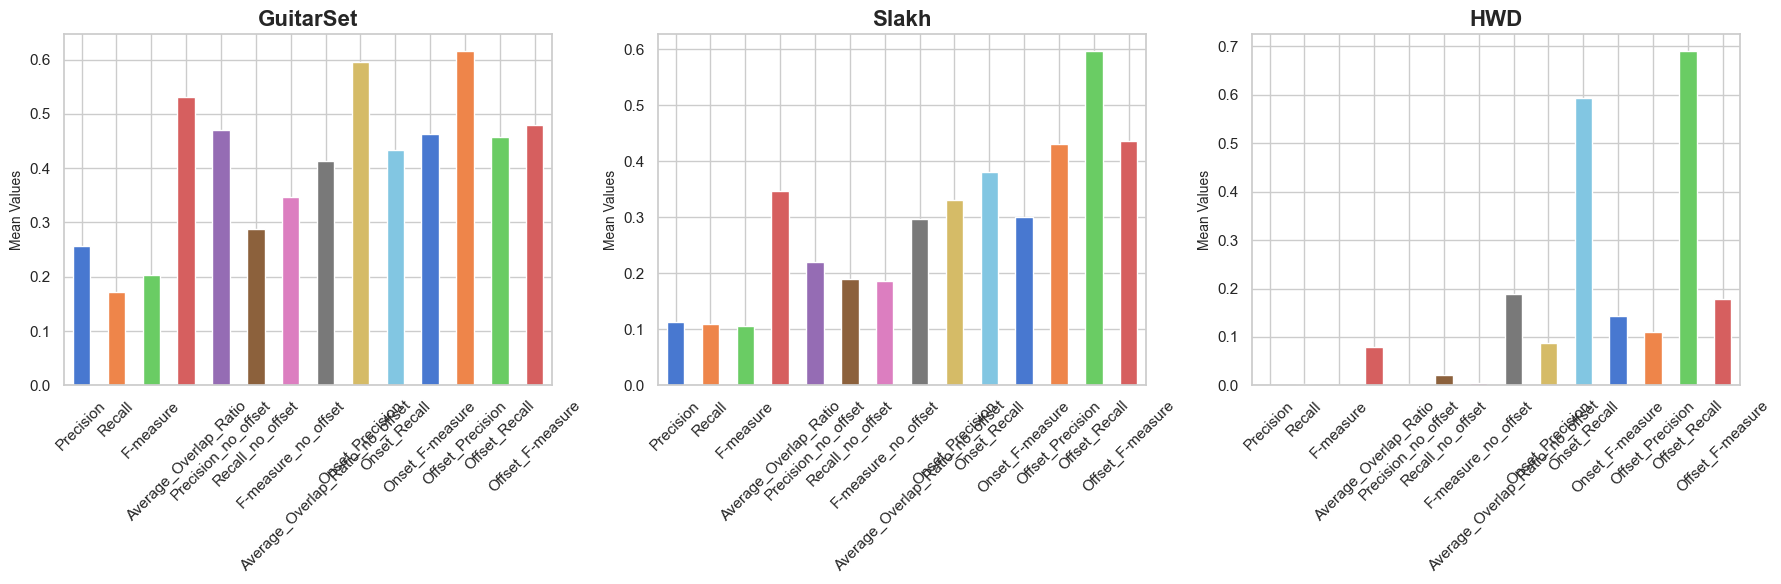

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the overall aesthetics
sns.set(style="whitegrid")

# Define the figure and axes
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Custom color palette
colors = sns.color_palette("muted")

# Plot each dataset with a consistent style
guitarset.describe().loc['mean'].plot(kind='bar', ax=ax[0], color=colors, title='GuitarSet')
slakh.describe().loc['mean'].plot(kind='bar', ax=ax[1], color=colors, title='Slakh')
hwd.describe().loc['mean'].plot(kind='bar', ax=ax[2], color=colors, title='HWD')

# Set titles with a larger font size
ax[0].set_title('GuitarSet', fontsize=16, weight='bold')
ax[1].set_title('Slakh', fontsize=16, weight='bold')
ax[2].set_title('HWD', fontsize=16, weight='bold')

# Rotate x-ticks for better readability
for a in ax:
    a.tick_params(axis='x', rotation=45)
    a.set_xlabel('')  # Remove default x-label
    a.set_ylabel('Mean Values', fontsize=10)
    a.grid(True)

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()


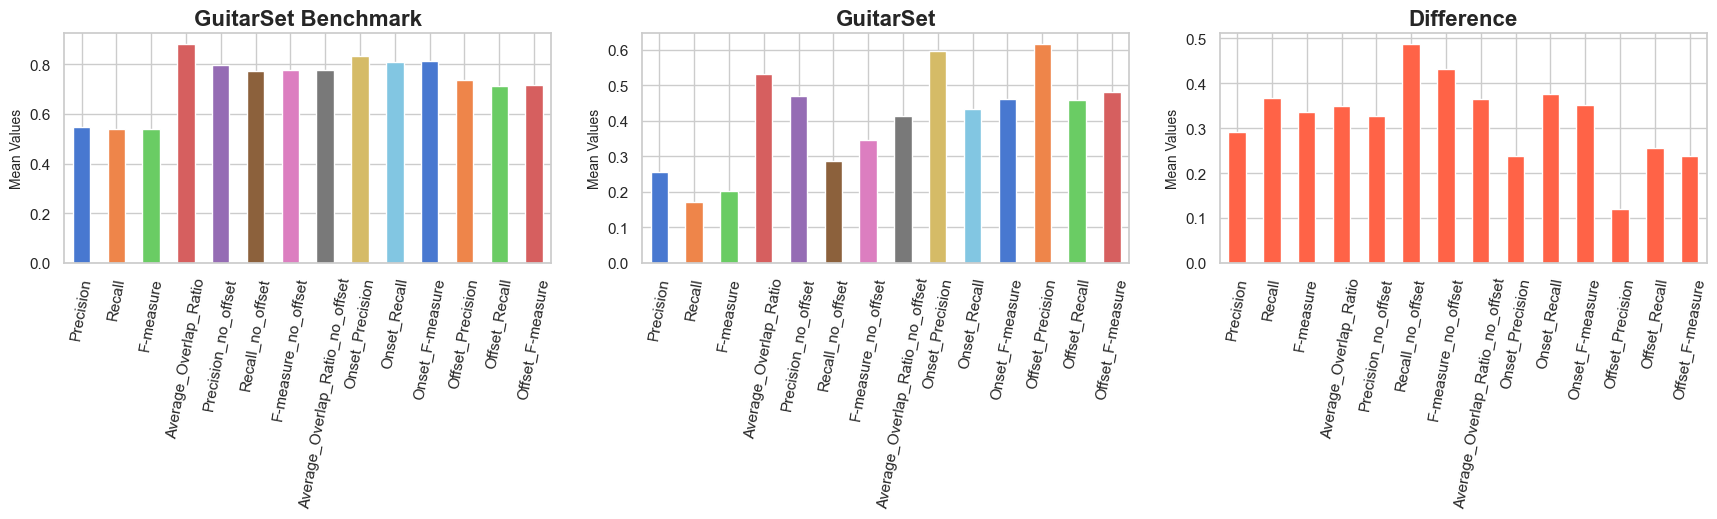

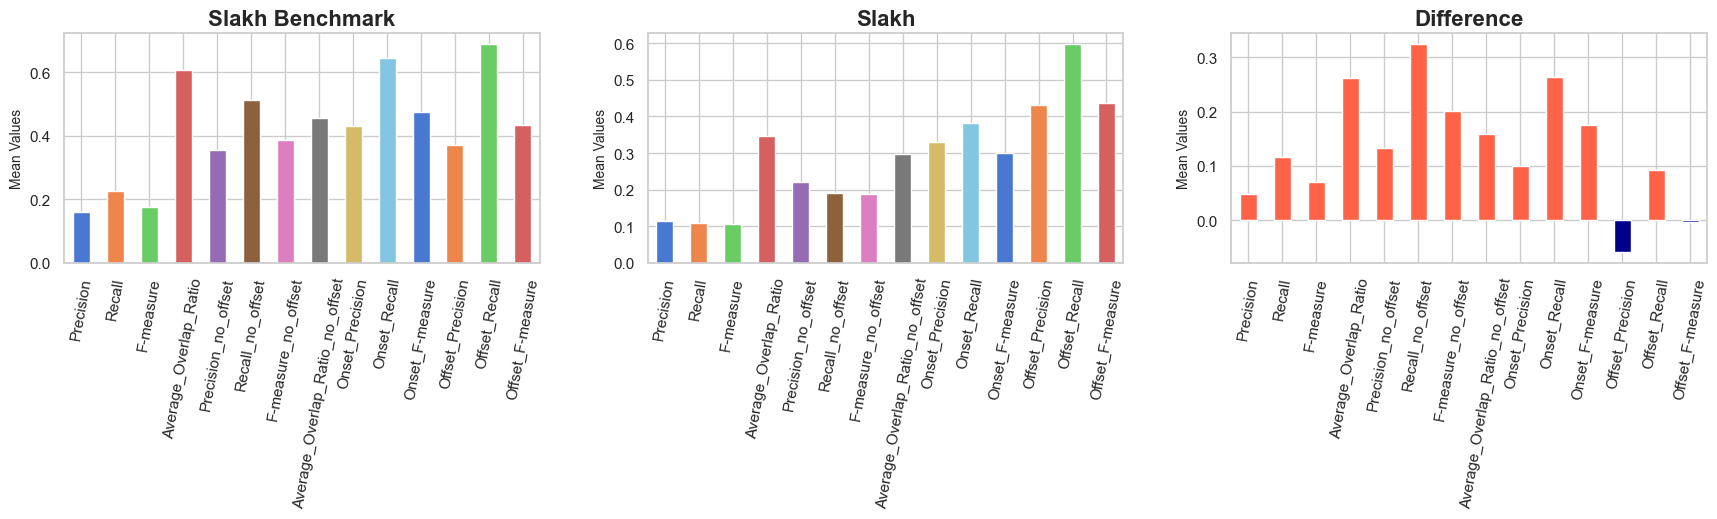

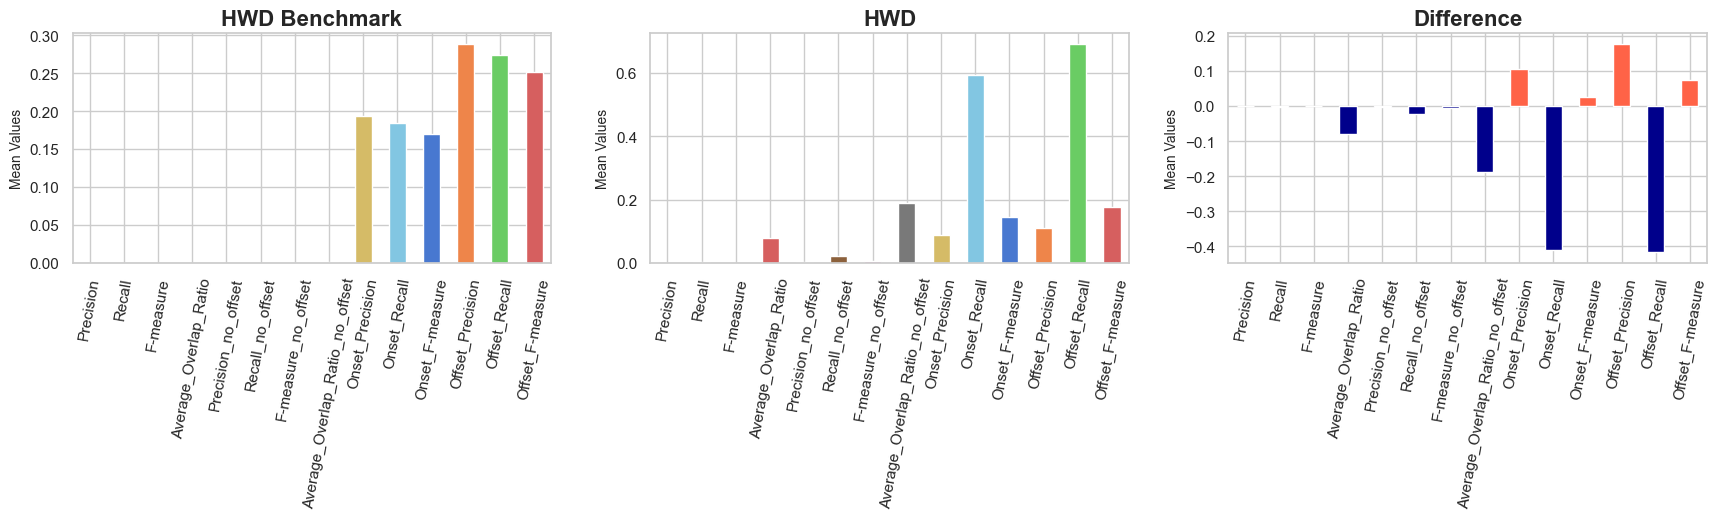

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the overall aesthetics
sns.set(style="whitegrid")

# Custom color palette
colors = sns.color_palette("muted")

# Function to plot comparison
def plot_comparison(data_b, data, dataset_name, ax):
    data_b.describe().loc['mean'].plot(kind='bar', ax=ax[0], color=colors, title=f'{dataset_name} Benchmark')
    data.describe().loc['mean'].plot(kind='bar', ax=ax[1], color=colors, title=dataset_name)
     # Calculate the difference
    differences = data_b.describe().loc['mean'] - data.describe().loc['mean']

    # Create a color map: red for negative, blue for positive
    colors_diff = ['darkblue' if val < 0 else 'tomato' for val in differences]

    # Plot the differences with conditional coloring
    differences.plot(kind='bar', ax=ax[2], color=colors_diff, title='Difference')
    # Set titles with a larger font size
    ax[0].set_title(f'{dataset_name} Benchmark', fontsize=16, weight='bold')
    ax[1].set_title(dataset_name, fontsize=16, weight='bold')
    ax[2].set_title('Difference', fontsize=16, weight='bold')

    # Rotate x-ticks for better readability
    for a in ax:
        a.tick_params(axis='x', rotation=80)  # Rotate and right-align
        a.set_xlabel('')  # Remove default x-label
        a.set_ylabel('Mean Values', fontsize=10)
        a.grid(True)

    # Adjust layout to avoid overlap
    plt.tight_layout(pad=3.0, w_pad=2.0)  # Increase padding between subplots

# Plot comparison between guitarset and guitarset_b
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
plot_comparison(guitarset_b, guitarset, 'GuitarSet', ax)
plt.show()

# Plot comparison between slakh and slakh_b
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
plot_comparison(slakh_b, slakh, 'Slakh', ax)
plt.show()

# Plot comparison between hwd and hwd_b
fig, ax = plt.subplots(1, 3, figsize=(18, 6))
plot_comparison(hwd_b, hwd, 'HWD', ax)
plt.show()
